In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from netCDF4 import Dataset
import pandas as pd
import properscoring as ps
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import warnings
import xarray as xr
from matplotlib import cm
from utils.evaluation import find_landfalling_tcs,tc_region,create_xarray,get_storm_coords
from utils.metrics import calculate_crps
from global_land_mask import globe
from scipy.interpolate import griddata
from utils.data import load_tc_data
from utils.plot import make_cmap
# from utils.metrics import calculate_fid
import xesmf as xe
import glob
warnings.filterwarnings("ignore")

sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))
sns.set_palette(sns.color_palette("Set2"))

# TODO: check which way the storms are rotating and how this is plotted - if using imshow it won't take into account
# the fact that mswep uses reverse latitude
# TODO: are the accumulated ones being plotted in the right places? like is it in the right order?

In [2]:
def plot_accumulated(data,lats,lons,vmin=0,vmax=200,plot='show',limit=1,cmap='Blues',title=False,levels=[0,50,100,150,200,250,300],centre_lats=None,centre_lons=None,intensity=None,ax=None,mask_oceans=False,cbar=False,cax=False,title_pos=False):
        """
        Plots the accumulated rainfall of a tropical cyclone while it's at tropical cyclone strength
        """
        data = np.where(data<limit,np.nan,data)
        lon2d,lat2d = np.meshgrid(lons,lats)
        if plot != 'ax':
                fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
        c = ax.contourf(lon2d,lat2d,data,vmin=vmin,vmax=vmax,levels=levels,cmap = cmap, transform=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
        ax.add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)
        if centre_lats is not None:
                for i in range(len(centre_lats)):
                        if intensity[i] == 0.0:
                                colour = '#ffb600'
                                colour='black'
                        elif intensity[i] == 1.0:
                                colour =  '#ff9e00'
                                colour='black'
                        elif intensity[i] == 2.0:
                                colour = '#ff7900'
                                colour='black'
                        elif intensity[i] == 3.0:       
                                colour = '#ff6000'
                                colour='black'
                        elif intensity[i] == 4.0:
                                colour = '#ff4000' 
                                colour='black'
                        elif intensity[i]==5.0:
                                colour = '#ff2000' 
                                colour='black'
                        ax.plot(centre_lons[i:i+2],centre_lats[i:i+2],color=colour,linewidth=2)
        ax.outline_patch.set_linewidth(0.5)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xlabel_style = {'size': 14}
        gl.ylabel_style = {'size': 14}
        # ax.set_xticklabels(labelsize=20)
        # ax.set_yticklabels(labelsize=20)
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        if plot != 'ax':
                cbar = plt.colorbar(c, shrink=0.78)
                # cbar.outline.set_linewidth(0.5)
                cbar.ax.tick_params(labelsize=6,width=0.5)
        
        if cbar == True:
                precip_cmap,precip_norm = make_cmap(high_vals=True)
                cbar = plt.colorbar(c,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',ax=cax)
                # cbar.ax.tick_params(labelsize=8,width=0.5)
                cbar.ax.tick_params(labelsize=20)

        if (title != False) and (title_pos == False):
                ax.set_title(title,fontsize=26,pad=15)
        elif (title != False) and (title_pos != False):
                x,y = title_pos
                print(x)
                print(y)
                ax.text(x,y,title,fontsize=30)
        

        if plot=='show':
                plt.show()
        elif plot=='save':
                plt.savefig('accumulated_rainfall.png',bbox_inches='tight',dpi=300)
        else:
                return ax

In [3]:
def accumulated_rain(storm,meta,real,pred_gan,inputs,flip=True):
	# grab mswep coordinate variables
	fp = '/bp1store/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
	d = Dataset(fp, 'r')
	lat = d.variables['lat'][:] #lat
	lon = d.variables['lon'][:] #lon
	print('lat shape: ',lat.shape)
	print('lon shape: ',lon.shape)
	# calculate lats and lons for storm
	lats,lons = tc_region(meta,storm,lat,lon)
	# initialise accumulated xarray
	# grid_x, grid_y = np.meshgrid(lats, lons)
	grid_x, grid_y = np.meshgrid(lons,lats)
	# a = np.zeros((grid_x.shape))
	print('grid_x shape: ',grid_x.shape)
	print('grid_y.shape: ', grid_y.shape)
	print('lons shape: ',lons.shape)
	print('lats shape: ',lats.shape)
	a = np.zeros((grid_y.shape))
	print('a shape',a.shape)
	accumulated_ds = create_xarray(lats,lons,a)
	accumulated_ds_pred = create_xarray(lats,lons,a)
	# accumulated_ds_input = create_xarray(lats,lons,a)
	# loop through storm time steps o generate accumulated rainfall
	for i in storm:
		storm_lats,storm_lons = get_storm_coords(lat,lon,meta,i)
		ds = create_xarray(storm_lats,storm_lons,real[i])
		ds_pred = create_xarray(storm_lats,storm_lons,pred_gan[i])
		input_lats,input_lons = get_storm_coords(np.arange(-89.5,90,1),np.arange(-179.5,180),meta,i)
		# ds_input = create_xarray(input_lats,input_lons,inputs[i])

		# if flip==True:
		# 	ds.precipitation.values = np.flip(ds.precipitation.values,axis=0)
		# 	ds_pred.precipitation.values = np.flip(ds_pred.precipitation.values,axis=0)

		# regrid so grids match
		regridder = xe.Regridder(ds, accumulated_ds, "bilinear")
		ds_out = regridder(ds)
		ds_pred_out = regridder(ds_pred)

		# regird the inputs
		# regridder = xe.Regridder(ds_input, accumulated_ds, "bilinear")
		# ds_input_out = regridder(ds_input)

		# add up rainfall
		accumulated_ds = accumulated_ds + ds_out
		accumulated_ds_pred = accumulated_ds_pred + ds_pred_out
		# accumulated_ds_input = accumulated_ds_input + ds_input_out

	return accumulated_ds,accumulated_ds_pred

In [4]:
# define mode
# mode = 'validation'
# mode = 'extreme_valid'
# load datasets
real,inputs,pred_cnn,pred_vaegan,pred_gan,pred_ensemble_vaegan,pred_ensemble_gan,meta = load_tc_data(set='validation',results='test')
real_x,inputs_x,pred_cnn_x,pred_vaegan_x,pred_gan_x,pred_vaegan_ensemble_x,pred_gan_ensemble_x,meta_extreme_valid = load_tc_data(set='extreme_valid',results='test')
# real_extreme_test,inputs_extreme_test,pred_cnn_extreme_test,pred_vaegan_extreme_test,pred_gan_extreme_test,pred_vaegan_ensemble_extreme_test,pred_gan_ensemble_extreme_test,meta_extreme_test = load_tc_data(set='extreme_test',results='test')
# inputs = np.load('/user/home/al18709/work/gan_predictions_20/validation_input-opt_improve.npy')[:,:,:,0]
hrmip = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3p/historical/storm_rain.npy')[-28000:]
tcs = pd.read_csv('/user/work/al18709/ibtracks/tc_files.csv')
# regrid inputs
grid_in = {"lon": np.linspace(0, 100, 10), "lat": np.linspace(0, 100, 10)}
grid_out = {"lon": np.linspace(0, 100, 100), "lat": np.linspace(0, 100, 100)}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
inputs_hr = regridder(inputs)
hrmip_hr = regridder(hrmip)

In [5]:
# get list of landfalling tcs
# landfall_sids = find_landfalling_tcs(meta)
valid_sids = list(dict.fromkeys(meta['sid']))
# get valid sids
# assign sid variable to list of sid indices correspoinnding to storm timesteps
for sid in valid_sids:
	indices = meta.sid[meta.sid == sid].index.tolist()
	exec('sid_%s = indices' % sid)

# get extreme sids
# landfall_sids = find_landfalling_tcs(meta_extreme_valid,land=False)
extreme_valid_sids = list(dict.fromkeys(meta_extreme_valid['sid']))
for sid in extreme_valid_sids:
	indices = meta_extreme_valid.sid[meta_extreme_valid.sid == sid].index.tolist()
	exec('sid_%s = indices' % sid)

# train_sids = list(dict.fromkeys(meta_train['sid']))
# for sid in train_sids:
# 	indices = meta_train.sid[meta_train.sid == sid].index.tolist()
# 	exec('sid_%s = indices' % sid)
# print('valid sids',valid_sids)

# print('extreme sids',extreme_valid_sids)
# print(all_sids)

In [6]:
# get tracks
tracks = pd.read_csv('/user/work/al18709/ibtracks/tc_files.csv')

In [10]:
# Irene 2011233N15301 validation NA
accumulated_ds_1,accumulated_ds_pred_1 = accumulated_rain(sid_2011233N15301,meta,real,pred_gan,inputs)

meta_irene = pd.read_csv('/user/work/al18709/tc_data_mswep_extend_flipped/meta_2011233N15301.csv')
irene_real = np.load('/user/home/al18709/work/gan_predictions_20/storm_real-opt_2011233N15301.npy')[:,:,:,0]
irene_pred = np.load('/user/home/al18709/work/gan_predictions_20/storm_pred-opt_2011233N15301.npy')[:,:,:,0]
irene_inputs = np.load('/user/home/al18709/work/gan_predictions_20/storm_input-opt_2011233N15301.npy')[:,:,:,0]
irene_inputs_hr = regridder(irene_inputs)
sid_2011233N15301 = np.arange(len(irene_real[:,0,0]))
accumulated_ds_1,accumulated_ds_pred_1 = accumulated_rain(sid_2011233N15301,meta_irene,irene_real,irene_pred,irene_inputs)
_,accumulated_ds_inputs_1 = accumulated_rain(sid_2011233N15301,meta_irene,irene_real,irene_inputs_hr,irene_inputs)
storm_1 = '2011233N15301'

# storm_1 = '2011233N15301'
# get tracks
centre_lats_1 = tracks['lat'].loc[tracks['sid']==storm_1].reset_index(drop=True)
centre_lons_1 = tracks['lon'].loc[tracks['sid']==storm_1].reset_index(drop=True)
intensity_1 = tracks['sshs'].loc[tracks['sid']==storm_1].reset_index(drop=True)

lat shape:  (1800,)
lon shape:  (3600,)
lat lower:  677
lat upper:  1372
lon lower:  1194
lon upper:  2641
lats:  (695,)
lons:  (1447,)
grid_x shape:  (695, 1447)
grid_y.shape:  (695, 1447)
lons shape:  (1447,)
lats shape:  (695,)
a shape (695, 1447)
lat shape:  (1800,)
lon shape:  (3600,)
lat lower:  1005
lat upper:  1383
lon lower:  974
lon upper:  1252
lats:  (378,)
lons:  (278,)
grid_x shape:  (378, 278)
grid_y.shape:  (378, 278)
lons shape:  (278,)
lats shape:  (378,)
a shape (378, 278)
lat shape:  (1800,)
lon shape:  (3600,)
lat lower:  1005
lat upper:  1383
lon lower:  974
lon upper:  1252
lats:  (378,)
lons:  (278,)
grid_x shape:  (378, 278)
grid_y.shape:  (378, 278)
lons shape:  (278,)
lats shape:  (378,)
a shape (378, 278)


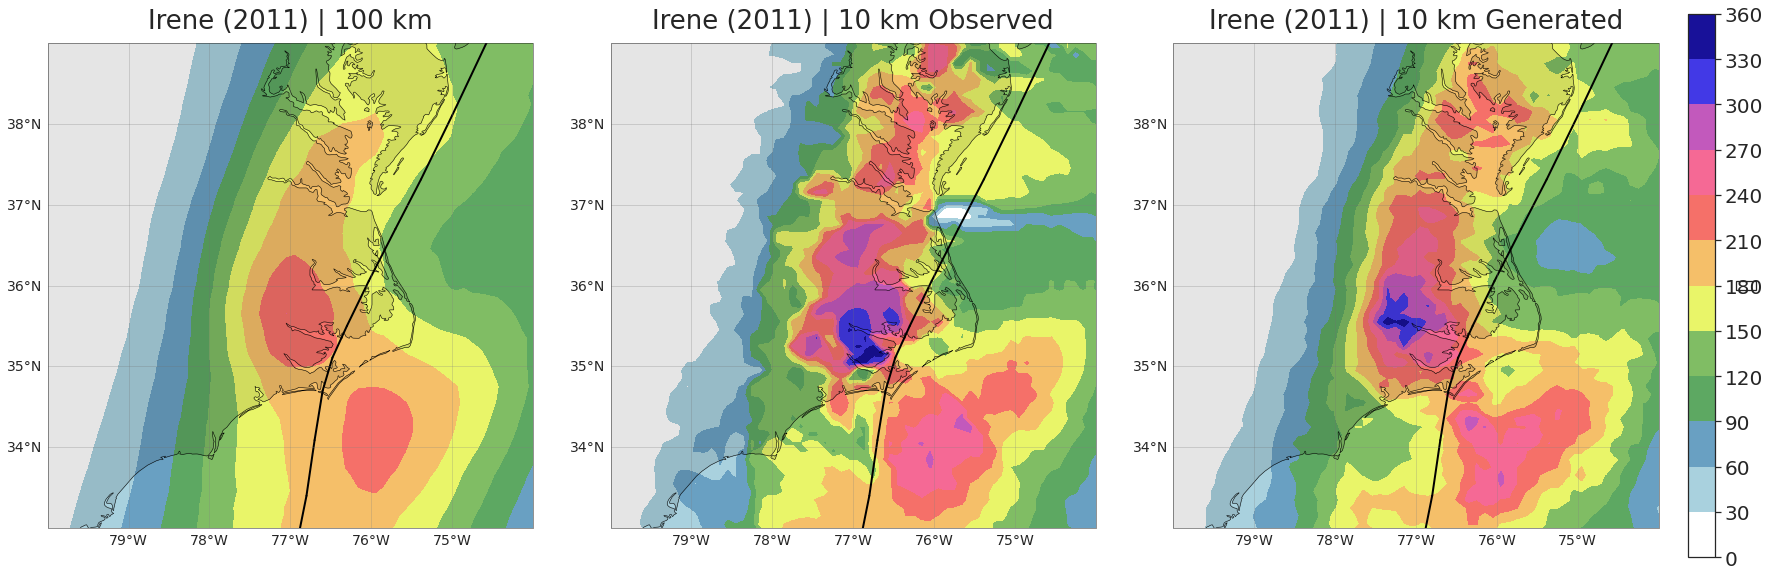

In [14]:
levels = [0, 1,2,3,4,6,10,15,20,25,40,50,100,150,200,250,300,350,400]
# levels = [0, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50]#100,150,200,250,300,350,400,500]
# levels = np.arange(0,500,10)
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,120,130, 150,180,200,250,300,350,400,450,500]
sns.set_style("white")
sns.set_context("notebook")
# define cmap
precip_cmap,precip_norm = make_cmap()

# gridspec = {'width_ratios': [1,1,0.2,1,1, 0.2]}
gridspec = {'width_ratios': [1,1,1,0.2]}
# fig, axes = plt.subplots(3, 6, figsize=(32, 20), sharey=False,subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw=gridspec)
fig, axes = plt.subplots(1, 4, figsize=(32, 10), sharey=False,subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw=gridspec)
# axes[0, 5].axis('off')
# axes[1, 5].axis('off')
# axes[2, 5].axis('off')
# # axes[3, 5].axis('off')
# axes[0, 2].axis('off')
# axes[1, 2].axis('off')
# axes[2, 2].axis('off')
# axes[3, 2].axis('off')

extent_1 = [119, 22, 122, 25]

# Irene 2011233N15301 validation NA
xlim_1 = (-80,-74)
ylim_1 = (33,39)


# Irene
levels = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
title = 'Irene (2011) | 100 km'
axes[0] = plot_accumulated(accumulated_ds_inputs_1['precipitation'],accumulated_ds_inputs_1['lat'].values,accumulated_ds_1['lon'].values,
							vmin=0,vmax=375,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_1,
							centre_lons=centre_lons_1,intensity=intensity_1,ax=axes[0],mask_oceans=True,title=title)


title = 'Irene (2011) | 10 km Observed'
axes[1] = plot_accumulated(accumulated_ds_1['precipitation'],accumulated_ds_1['lat'].values,accumulated_ds_1['lon'].values,
							vmin=0,vmax=375,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_1,
							centre_lons=centre_lons_1,intensity=intensity_1,ax=axes[1],mask_oceans=True,title=title)
title = 'Irene (2011) | 10 km Generated'
axes[2] = plot_accumulated(accumulated_ds_pred_1['precipitation'],accumulated_ds_pred_1['lat'].values,accumulated_ds_pred_1['lon'].values,
							vmin=0,vmax=375,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_1,centre_lons=centre_lons_1,
							intensity=intensity_1,ax=axes[2],mask_oceans=True,title=title,cbar=True,cax=axes[3])
axes[0].set_xlim(xlim_1)
axes[0].set_ylim(ylim_1)
axes[1].set_xlim(xlim_1)
axes[1].set_ylim(ylim_1)
axes[2].set_xlim(xlim_1)
axes[2].set_ylim(ylim_1)


plt.savefig('irene.png',bbox_inches='tight',dpi=600)